# Real time Twitter Sentiment Analysis with PySpark

## Install required packages and libraries

In [ ]:
!pip install pyspark
#!pip install kaggle
#!pip install wordcloud

## Import the required packages and libraries

In [ ]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk

## Load the Data from Kaggle





In [ ]:
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kazanova/sentiment140
!unzip -o sentiment140.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:05<00:00, 21.5MB/s]
100% 80.9M/80.9M [00:05<00:00, 15.4MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Start the Spark session

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('EfficientModeling') \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()
spark

## Loading the data in Spark Dataframe

In [ ]:
df = spark.read.csv("training.1600000.processed.noemoticon.csv", inferSchema=True)

In [ ]:
df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

#### Renaming the columns

In [ ]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

#### Checking the Schema

In [ ]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



## Inspect and Preprocessing the Dataset

In [ ]:
df.head(5)

[Row(target=0, id=1467810369, date='Mon Apr 06 22:19:45 PDT 2009', flag='NO_QUERY', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(target=0, id=1467810672, date='Mon Apr 06 22:19:49 PDT 2009', flag='NO_QUERY', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(target=0, id=1467810917, date='Mon Apr 06 22:19:53 PDT 2009', flag='NO_QUERY', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'),
 Row(target=0, id=1467811184, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='ElleCTF', text='my whole body feels itchy and like its on fire '),
 Row(target=0, id=1467811193, date='Mon Apr 06 22:19:57 PDT 2009', flag='NO_QUERY', user='Karoli', text="@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because

In [ ]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  6 columns in the dataset.


#### Check for missing values!!

In [ ]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,target,id,date,flag,user,text
0,0,0,0,0,0,0


There are no missing values in the dataset.

#### Check for duplicates!!

In [ ]:
df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


There are no duplicates in the dataset.

#### Check types of columns!!

In [ ]:
df.dtypes

[('target', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('flag', 'string'),
 ('user', 'string'),
 ('text', 'string')]

#### Summary of the Dataframe

In [ ]:
df.summary().show()
df.describe().show()

+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|            target|                  id|                date|    flag|                user|                text|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|               2.0|1.9988175522956276E9|                NULL|    NULL| 4.325887521835714E9|                NULL|
| stddev|2.0000006250002933|1.9357607362267622E8|                NULL|    NULL|5.162733218454887...|                NULL|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    25%|                 0|          1956913731|                NULL|    NULL|             32508.0|                NULL|
|    50%|               

We only need the target and the text column for sentiment analyses, that's why dropping the rest of the columns.

In [ ]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)

In [ ]:
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
df.show(5, truncate = False)

+------+----------------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                                        |
+------+----------------------------------------------------------------------------------------------------------------------------+
|0     |At work                                                                                                                     |
|0     |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0     |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0     |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0     |really now, time for sleep. dreaming of my city, more 

In [ ]:
df.select("target").distinct().show()

+------+
|target|
+------+
|     0|
|     4|
+------+



There are only two distinct values in target column. O for "Negative" and 4 for "Positive" according to data description. Let's change the value of Positive from 4 to 1.

In [ ]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.show(5, truncate = False)

+-----+----------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                        |
+-----+----------------------------------------------------------------------------------------------------------------------------+
|0.0  |At work                                                                                                                     |
|0.0  |@astewart87 oh my gosh that made me emotional haha idk why!!! i dont want to get old                                        |
|0.0  |i need new glasses...mines is hangnon 1 arm                                                                                 |
|0.0  |Getting changed in the hopes that, that means we can go to the store now!  Poor cat is out of food...oops.                  |
|0.0  |really now, time for sleep. dreaming of my city, more tattoos,

In [ ]:
df.tail(5)

[Row(label=Decimal('1.0'), text='Installing office to my little netbook, going to do some work at a friends house in a short while. '),
 Row(label=Decimal('1.0'), text='man.. Ab got work.. ahhh!!! but later imma shop till i drop!! '),
 Row(label=Decimal('1.0'), text="@paupaula I'm joining The SPectrum maybe. Idk... But yeah I'm dedicating myself to my studies too  How? Idk."),
 Row(label=Decimal('1.0'), text='Friend over  My god! 300th Update!!'),
 Row(label=Decimal('1.0'), text='TIME MAG ONLINE is very interesting. Watching videos this morning. Enjoying free content... while it lasts. ')]

In [ ]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



## Text Preprocessing

#### Remove stopwords, punctuations, links, and stem the data

In [ ]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 3.85 ms, sys: 974 µs, total: 4.83 ms
Wall time: 31.3 ms


In [ ]:
df.show()

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|            At work |                work|
|  0.0|@astewart87 oh my...|oh gosh made emot...|
|  0.0|i need new glasse...|need new glasses ...|
|  0.0|Getting changed i...|getting changed h...|
|  0.0|really now, time ...|really time sleep...|
|  0.0|pfff i want to go...|pfff want go back...|
|  0.0|Currently watchin...|currently watchin...|
|  0.0|What a bad day! N...|bad day need comf...|
|  0.0|Tried to install ...|tried install twi...|
|  0.0|Having casual, un...|casual unprotecte...|
|  0.0|Good morning worl...|good morning worl...|
|  0.0|@pmarnandus re: d...|daily gossip well...|
|  0.0|Someone somewhere...|someone somewhere...|
|  0.0|@weblivz What a b...|boot would demand...|
|  0.0|@jobeaz damn, sor...|damn sorry missed...|
|  0.0|@klariza that's a...|awesome love stuf...|
|  0.0|my tv husbands ri...|tv husbands rick ...|


In [ ]:
df = df.drop("text")

## Displaying Word Cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
pandas_df = df.toPandas()
pandas_df.head()

,label,text_cleaned
0,0.0,work
1,0.0,oh gosh made emotional haha idk dont want get old
2,0.0,need new glasses mines hangnon 1 arm
3,0.0,getting changed hopes means go store poor cat ...
4,0.0,really time sleep dreaming city tattoos great ...


#### Positive Sentiments Word Cloud

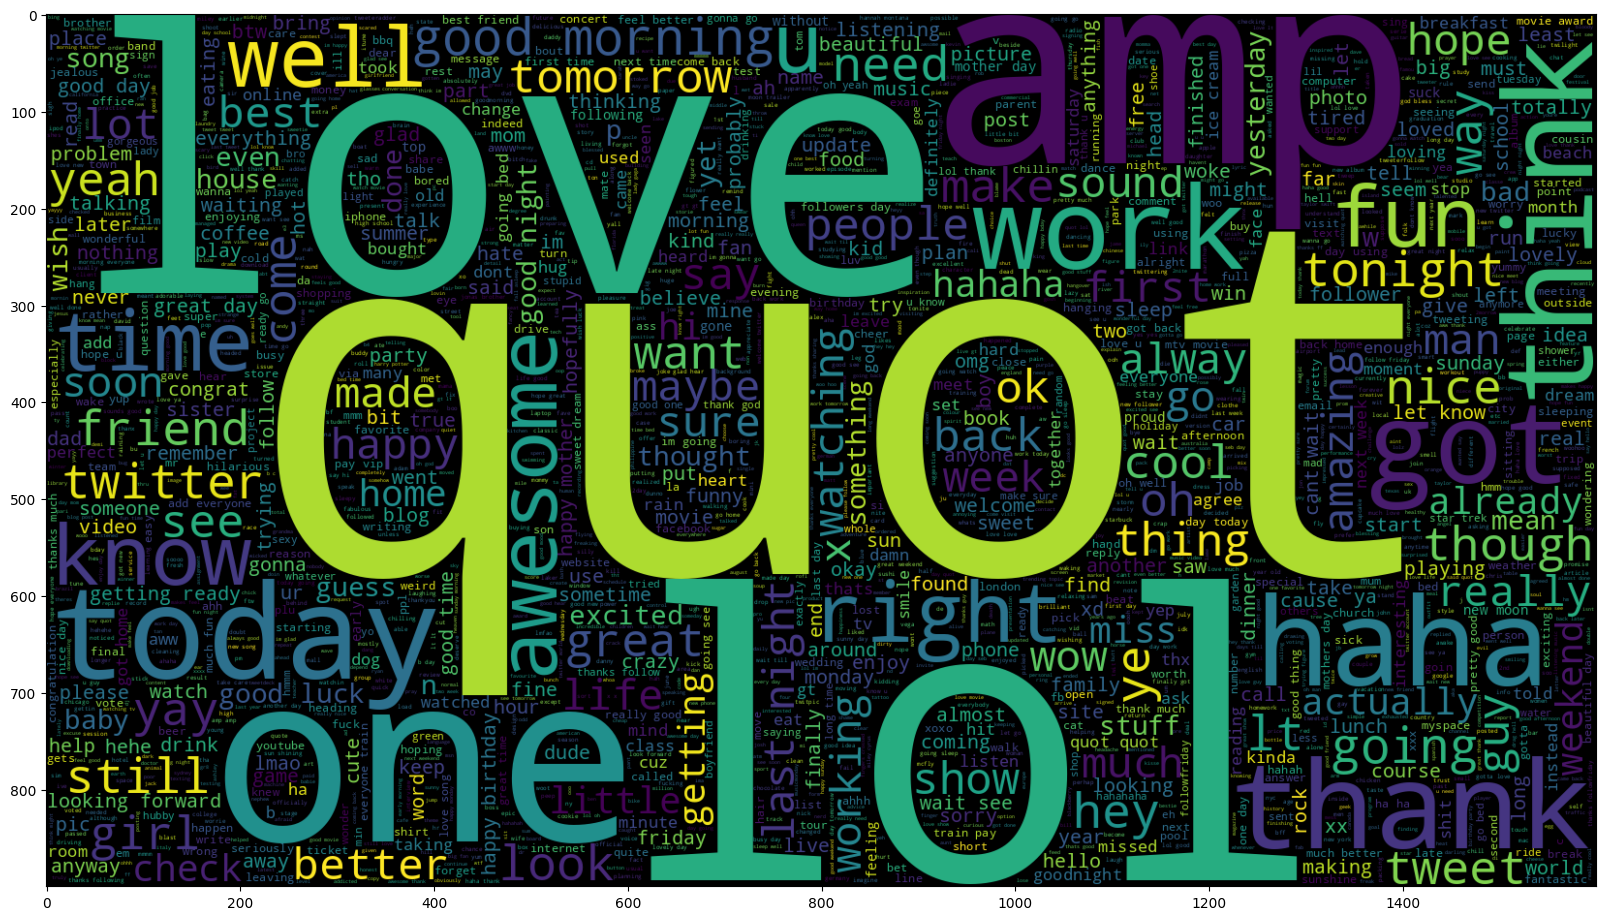

In [ ]:
plt.figure(figsize = (20,16))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Sentiments Word Cloud

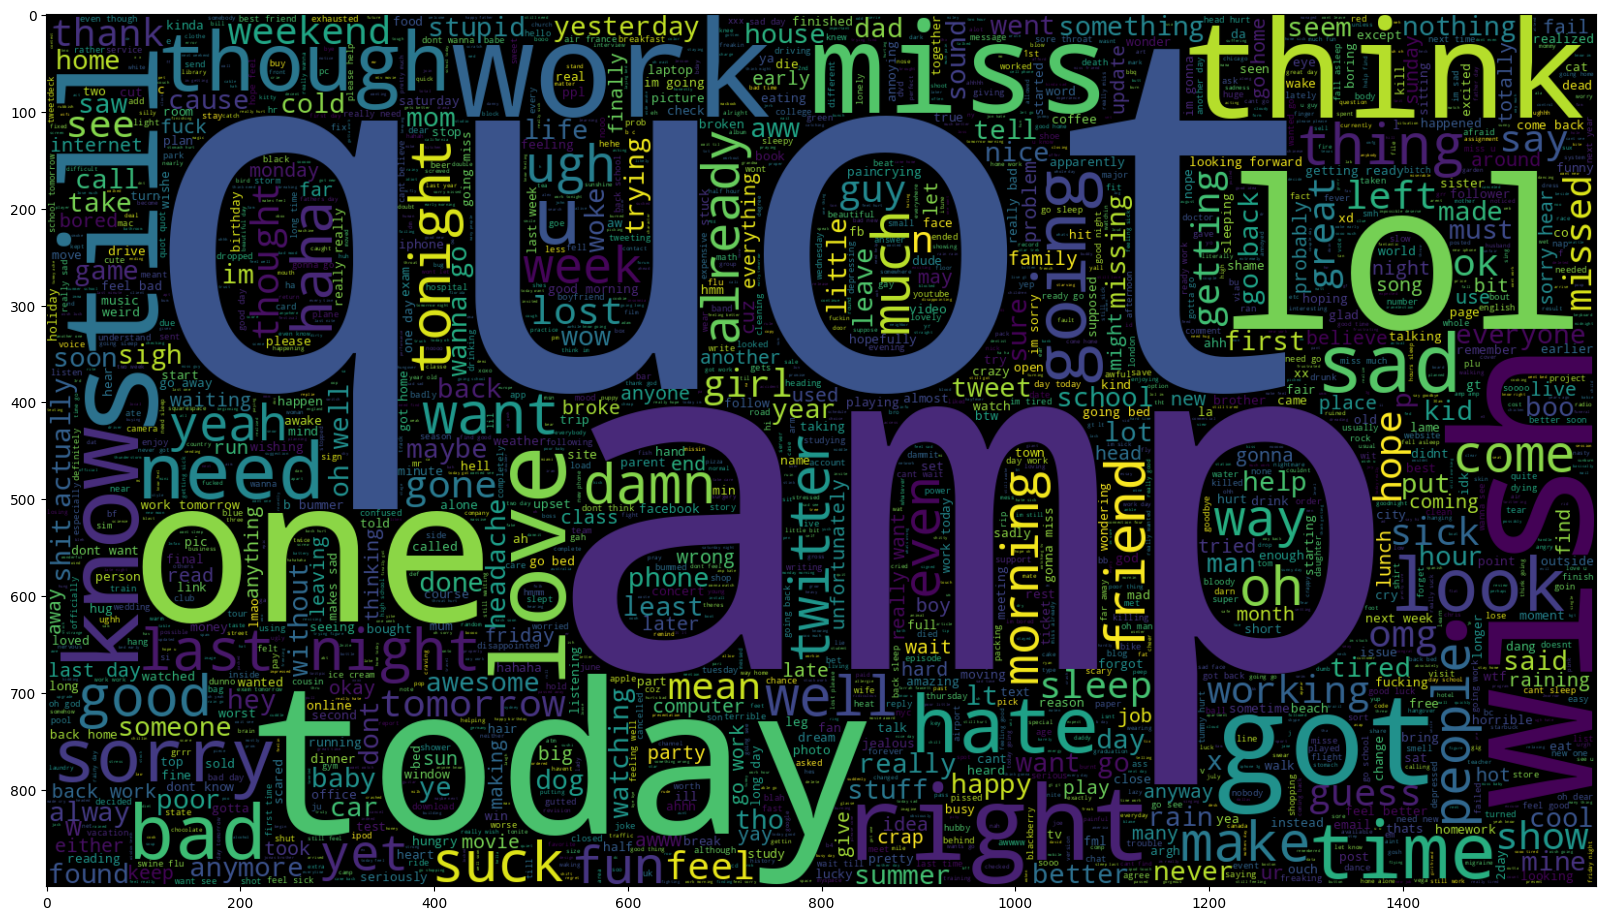

In [ ]:
plt.figure(figsize = (20,16))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 900).generate(" ".join(pandas_df[pandas_df["label"]==0.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

## Preparing Data for Model Building

#### Tokenizing the Text

In [ ]:
from pyspark.ml.feature import Tokenizer

In [ ]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show()

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|                work|              [work]|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|
|  0.0|need new glasses ...|[need, new, glass...|
|  0.0|getting changed h...|[getting, changed...|
|  0.0|really time sleep...|[really, time, sl...|
|  0.0|pfff want go back...|[pfff, want, go, ...|
|  0.0|currently watchin...|[currently, watch...|
|  0.0|bad day need comf...|[bad, day, need, ...|
|  0.0|tried install twi...|[tried, install, ...|
|  0.0|casual unprotecte...|[casual, unprotec...|
|  0.0|good morning worl...|[good, morning, w...|
|  0.0|daily gossip well...|[daily, gossip, w...|
|  0.0|someone somewhere...|[someone, somewhe...|
|  0.0|boot would demand...|[boot, would, dem...|
|  0.0|damn sorry missed...|[damn, sorry, mis...|
|  0.0|awesome love stuf...|[awesome, love, s...|
|  0.0|tv husbands rick ...|[tv, husbands, ri...|


#### Applying CountVectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
count = CountVectorizer (inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show()

+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+
|  0.0|                work|              [work]|  (262144,[7],[1.0])|
|  0.0|oh gosh made emot...|[oh, gosh, made, ...|(262144,[2,26,30,...|
|  0.0|need new glasses ...|[need, new, glass...|(262144,[25,33,10...|
|  0.0|getting changed h...|[getting, changed...|(262144,[4,56,235...|
|  0.0|really time sleep...|[really, time, sl...|(262144,[12,18,35...|
|  0.0|pfff want go back...|[pfff, want, go, ...|(262144,[4,6,13,2...|
|  0.0|currently watchin...|[currently, watch...|(262144,[5,32,61,...|
|  0.0|bad day need comf...|[bad, day, need, ...|(262144,[1,33,48,...|
|  0.0|tried install twi...|[tried, install, ...|(262144,[7,39,121...|
|  0.0|casual unprotecte...|[casual, unprotec...|(262144,[20,81,20...|
|  0.0|good morning worl...|[good, morning, w...|(262144,[0,10,35,...|
|  0.0

#### Applying Term Frequency - Inverse Document Frequency (TF-IDF)

In [ ]:
from pyspark.ml.feature import IDF

In [ ]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[7],[3.24...|
|  0.0|(262144,[2,26,30,...|
|  0.0|(262144,[25,33,10...|
|  0.0|(262144,[4,56,235...|
|  0.0|(262144,[12,18,35...|
|  0.0|(262144,[4,6,13,2...|
|  0.0|(262144,[5,32,61,...|
|  0.0|(262144,[1,33,48,...|
|  0.0|(262144,[7,39,121...|
|  0.0|(262144,[20,81,20...|
|  0.0|(262144,[0,10,35,...|
|  0.0|(262144,[24,39,40...|
|  0.0|(262144,[3,147,98...|
|  0.0|(262144,[15,49,29...|
|  0.0|(262144,[21,51,14...|
|  0.0|(262144,[8,31,78,...|
|  0.0|(262144,[66,201,3...|
|  0.0|(262144,[8,31,124...|
|  0.0|(262144,[157,256,...|
|  0.0|(262144,[176,317,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
df_final = rescaledData.select("label", "features")# We want only the label and features columns for our machine learning models

#### Splitting the data into training and test dataset

In [ ]:
seed = 42  # set seed for reproducibility

trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [ ]:
trainDF.count()

1120688

In [ ]:
trainDF.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|      (262144,[],[])|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[2.90...|
|  0.0|(262144,[0],[5.81...|
|  0.0|(262144,[0,1,2,4,...|
|  0.0|(262144,[0,1,2,6,...|
|  0.0|(262144,[0,1,2,6,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
trainDF.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|560337|
|  1.0|560351|
+-----+------+



In [ ]:
testDF.count()

479312

## Training the Model

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes

Logistic Regression Model

In [ ]:
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
lr_model = lr.fit(trainDF)
lr_predictions = lr_model.transform(testDF)

**Naive Bayes Model**

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="label", featuresCol="features")
nb_model = nb.fit(trainDF)
nb_predictions = nb_model.transform(testDF)

**SVM model**

In [ ]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol="label", featuresCol="features")
lsvc_model = lsvc.fit(trainDF)
lsvc_predictions = lsvc_model.transform(testDF)

In [ ]:
lr_pred = lr_predictions.toPandas()
nb_pred = nb_predictions.toPandas()
lsvc_pred = lsvc_predictions.toPandas()
lr_pred.head()

,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26156926594438923, 0.26156926594438923]","[0.43497798707238217, 0.5650220129276178]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26156926594438923, 0.26156926594438923]","[0.43497798707238217, 0.5650220129276178]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26156926594438923, 0.26156926594438923]","[0.43497798707238217, 0.5650220129276178]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26156926594438923, 0.26156926594438923]","[0.43497798707238217, 0.5650220129276178]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.26156926594438923, 0.26156926594438923]","[0.43497798707238217, 0.5650220129276178]",1.0


## Evaluating the Model

Area Under ROC (AUC) for Logistic Regression: 0.8171
Area Under ROC (AUC) for Naive Bayes: 0.5173
Area Under ROC (AUC) for SVM: 0.8404


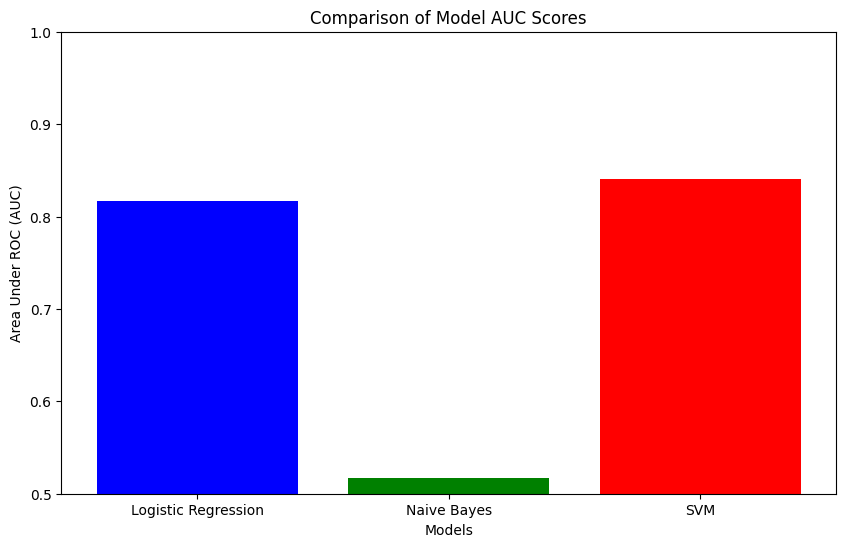

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

evaluator = BinaryClassificationEvaluator(labelCol="label")

# Evaluate each model
lr_areaUnderROC = evaluator.evaluate(lr_predictions)
nb_areaUnderROC = evaluator.evaluate(nb_predictions)
lsvc_areaUnderROC = evaluator.evaluate(lsvc_predictions)

# Print the AUC scores
print(f"Area Under ROC (AUC) for Logistic Regression: {lr_areaUnderROC:.4f}")
print(f"Area Under ROC (AUC) for Naive Bayes: {nb_areaUnderROC:.4f}")
print(f"Area Under ROC (AUC) for SVM: {lsvc_areaUnderROC:.4f}")

# Visualize AUC Scores
auc_scores = [lr_areaUnderROC, nb_areaUnderROC, lsvc_areaUnderROC]
models = ['Logistic Regression', 'Naive Bayes', 'SVM']

plt.figure(figsize=(10, 6))
plt.bar(models, auc_scores, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Area Under ROC (AUC)')
plt.title('Comparison of Model AUC Scores')
plt.ylim(0.5, 1.0)  # Adjust y-axis to show AUC score range
plt.show()


Area Under ROC for Logistic Regression: 0.8171
Area Under ROC for Naive Bayes: 0.5173
Area Under ROC for SVM: 0.8404


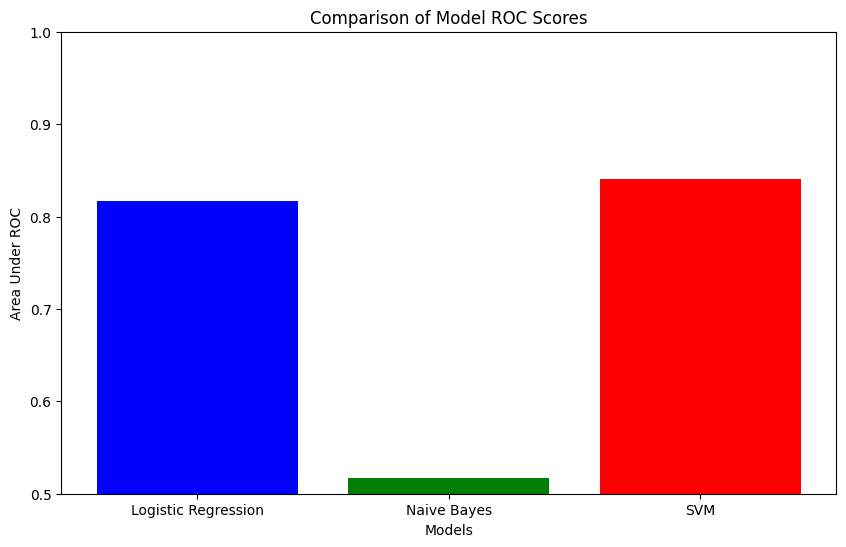

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Calculate the AUC for each model
lr_areaUnderROC = evaluator.evaluate(lr_predictions)
nb_areaUnderROC = evaluator.evaluate(nb_predictions)
lsvc_areaUnderROC = evaluator.evaluate(lsvc_predictions)

# Print the AUC scores
print(f"Area Under ROC for Logistic Regression: {lr_areaUnderROC:.4f}")
print(f"Area Under ROC for Naive Bayes: {nb_areaUnderROC:.4f}")
print(f"Area Under ROC for SVM: {lsvc_areaUnderROC:.4f}")

# Data for plotting
roc_scores = [lr_areaUnderROC, nb_areaUnderROC, lsvc_areaUnderROC]
models = ['Logistic Regression', 'Naive Bayes', 'SVM']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, roc_scores, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Area Under ROC')
plt.title('Comparison of Model ROC Scores')
plt.ylim(0.5, 1.0)  # Adjust y-axis to show ROC score range
plt.show()

#### Classification Report and Confusion Matrix

In [ ]:
y_true = lr_pred['label'].astype('float')
y_pred = lr_pred['prediction']

In [ ]:
y_true.value_counts()

,count
label,
0.0,239663
1.0,239649


In [ ]:
y_pred.value_counts()

,count
prediction,
1.0,247365
0.0,231947


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Ensure the label and prediction columns are of integer type for all models
lr_pred['label'] = lr_pred['label'].astype(int)
lr_pred['prediction'] = lr_pred['prediction'].astype(int)

nb_pred['label'] = nb_pred['label'].astype(int)
nb_pred['prediction'] = nb_pred['prediction'].astype(int)

lsvc_pred['label'] = lsvc_pred['label'].astype(int)
lsvc_pred['prediction'] = lsvc_pred['prediction'].astype(int)

# Now, generate classification reports
print("Logistic Regression Classification Report:")
print(classification_report(lr_pred['label'], lr_pred['prediction']))

print("Naive Bayes Classification Report:")
print(classification_report(nb_pred['label'], nb_pred['prediction']))

print("SVM Classification Report:")
print(classification_report(lsvc_pred['label'], lsvc_pred['prediction']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76    239663
           1       0.75      0.78      0.76    239649

    accuracy                           0.76    479312
   macro avg       0.76      0.76      0.76    479312
weighted avg       0.76      0.76      0.76    479312

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75    239663
           1       0.75      0.73      0.74    239649

    accuracy                           0.75    479312
   macro avg       0.75      0.75      0.75    479312
weighted avg       0.75      0.75      0.75    479312

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    239663
           1       0.76      0.79      0.77    239649

    accuracy                           0.77    479312
   macro avg       0.77

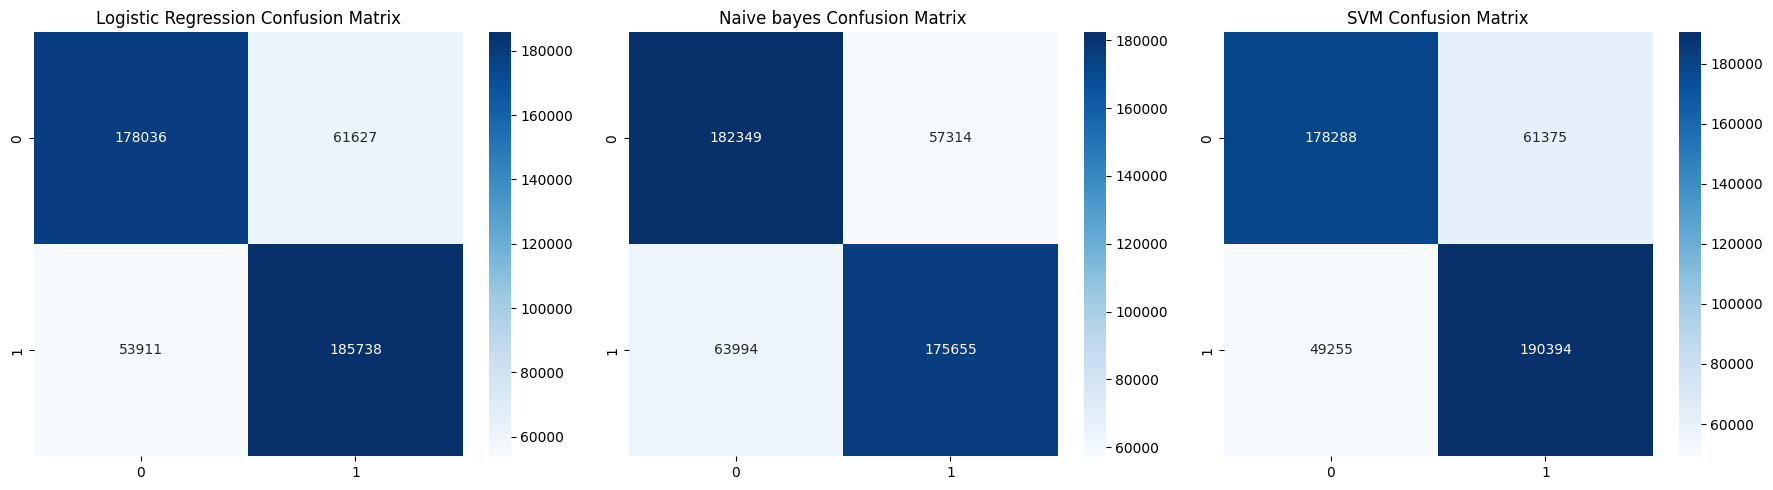

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(confusion_matrix(lr_pred['label'], lr_pred['prediction']), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(confusion_matrix(nb_pred['label'], nb_pred['prediction']), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Naive bayes Confusion Matrix')

sns.heatmap(confusion_matrix(lsvc_pred['label'], lsvc_pred['prediction']), annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr_accuracy = accuracy_score(lr_pred['label'], lr_pred['prediction'])
nb_accuracy = accuracy_score(nb_pred['label'], nb_pred['prediction'])
lsvc_accuracy = accuracy_score(lsvc_pred['label'], lsvc_pred['prediction'])

lr_precision = precision_score(lr_pred['label'], lr_pred['prediction'], average='weighted')
nb_precision = precision_score(nb_pred['label'], nb_pred['prediction'], average='weighted')
lsvc_precision = precision_score(lsvc_pred['label'], lsvc_pred['prediction'], average='weighted')

lr_recall = recall_score(lr_pred['label'], lr_pred['prediction'], average='weighted')
nb_recall = recall_score(nb_pred['label'], nb_pred['prediction'], average='weighted')
lsvc_recall = recall_score(lsvc_pred['label'], lsvc_pred['prediction'], average='weighted')

lr_f1 = f1_score(lr_pred['label'], lr_pred['prediction'], average='weighted')
nb_f1 = f1_score(nb_pred['label'], nb_pred['prediction'], average='weighted')
lsvc_f1 = f1_score(lsvc_pred['label'], lsvc_pred['prediction'], average='weighted')

In [ ]:
metrics = {
    'Accuracy': [lr_accuracy, nb_accuracy, lsvc_accuracy],
    'Precision': [lr_precision, nb_precision, lsvc_precision],
    'Recall': [lr_recall, nb_recall, lsvc_recall],
    'Area Under ROC': [lr_areaUnderROC, nb_areaUnderROC, lsvc_areaUnderROC],
    'F1 Score': [lr_f1, nb_f1, lsvc_f1]
}

metrics_df = pd.DataFrame(metrics, index=['Logistic Regression', 'Naive Bayes', 'SVM'])

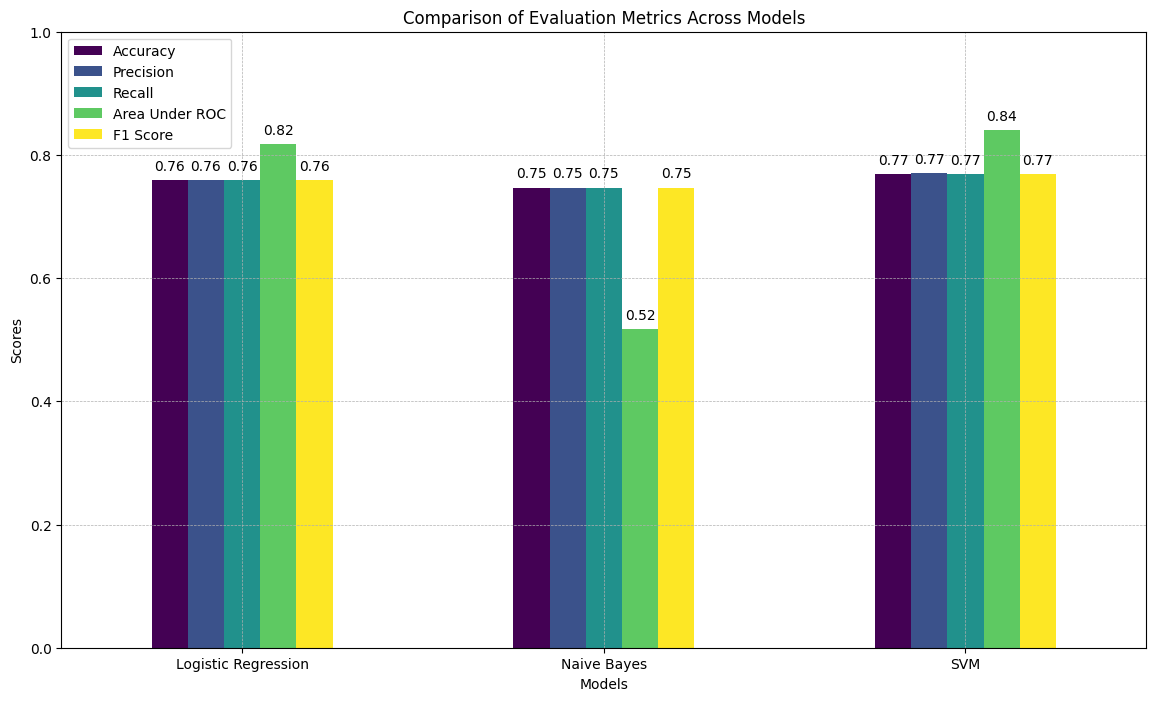

In [ ]:
import matplotlib.pyplot as plt

# Plotting
ax = metrics_df.plot(kind='bar', figsize=(14, 8), colormap='viridis')  # Using a colormap for better color distinction

# Adding some customizations
plt.title('Comparison of Evaluation Metrics Across Models')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.xticks(rotation=0)  # Keeps the model names horizontal
plt.ylim(0, 1)  # Adjust y-axis to fit [0,1] for metrics like accuracy, precision, recall, F1, and AUC (if included)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding the values on top of the bars for better readability
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

# `Saving and downolading the models`

In [ ]:
lr_model.save('/content/logistic_regression_model')
nb_model.save('/content/naive_bayes_model')
lsvc_model.save('/content/SVM_model')

!zip -r naive_bayes_model.zip /content/naive_bayes_model
!zip -r SVM_model.zip /content/SVM_model
!zip -r logistic_regression_model.zip /content/logistic_regression_model

files.download('naive_bayes_model.zip')
files.download('SVM_model.zip')
files.download('logistic_regression_model.zip')

  adding: content/naive_bayes_model/ (stored 0%)
  adding: content/naive_bayes_model/metadata/ (stored 0%)
  adding: content/naive_bayes_model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/naive_bayes_model/metadata/_SUCCESS (stored 0%)
  adding: content/naive_bayes_model/metadata/.part-00000.crc (stored 0%)
  adding: content/naive_bayes_model/metadata/part-00000 (deflated 48%)
  adding: content/naive_bayes_model/data/ (stored 0%)
  adding: content/naive_bayes_model/data/._SUCCESS.crc (stored 0%)
  adding: content/naive_bayes_model/data/_SUCCESS (stored 0%)
  adding: content/naive_bayes_model/data/part-00000-c4a4060a-37f4-455e-bce6-c6283ff9e151-c000.snappy.parquet (deflated 14%)
  adding: content/naive_bayes_model/data/.part-00000-c4a4060a-37f4-455e-bce6-c6283ff9e151-c000.snappy.parquet.crc (stored 0%)
  adding: content/SVM_model/ (stored 0%)
  adding: content/SVM_model/metadata/ (stored 0%)
  adding: content/SVM_model/metadata/._SUCCESS.crc (stored 0%)
  adding: content/SVM_mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>